![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

## Lecture 4 Support Notebook

### Table of Contents
<p>
<div class="lev1">
    <a href="#K-armed-Bandit-Problem">
        <span class="toc-item-num">1.&nbsp;&nbsp;</span>
        K-armed Bandit Problem
    </a>
</div>
<div class="lev1">
    <a href="#Ten-armed-Testbed-I"><span class="toc-item-num">2.&nbsp;&nbsp;</span>
        Ten-armed Testbed I
    </a>
</div>
<div class="lev1">
    <a href="#Ten-armed-Testbed-II"><span class="toc-item-num">2.&nbsp;&nbsp;</span>
        Ten-armed Testbed II
    </a>
</div>
<div class="lev1">
    <a href="#Optimistic-Initial-Values"><span class="toc-item-num">3.&nbsp;&nbsp;</span>
        Optimistic Initial Values
    </a>
</div>
<div class="lev1">
    <a href="#Upper-Confidence-Bound-Action-Selection"><span class="toc-item-num">4.&nbsp;&nbsp;</span>
        Upper-Confidence-Bound Action Selection
    </a>
</div>
<div class="lev1">
    <a href="#Gradient-Bandits"><span class="toc-item-num">5.&nbsp;&nbsp;</span>
        Gradient Bandits
    </a>
</div>
<div class="lev1">
    <a href="#Parameter-Study-Graphs"><span class="toc-item-num">6.&nbsp;&nbsp;</span>
        Parameter Study Graphs
    </a>
</div>

# TOP

# K-armed Bandit Problem
This is a simple example of how to build a policy-gradient based agent that can solve the multi-armed bandit problem. For more information, see this [Medium post](https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-1-fd544fab149).

In [1]:
import tensorflow as tf
import numpy as np

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.i

### The Bandits
Here we define our bandits. For this example we are using a four-armed bandit. The pullBandit function generates a random number from a normal distribution with a mean of 0. The lower the bandit number, the more likely a positive reward will be returned. We want our agent to learn to always choose the bandit that will give that positive reward.

In [2]:
#List out our bandits. Currently bandit 4 (index#3) is set to most often provide a positive reward.
bandits = [0.2,0,-0.2,-5]
num_bandits = len(bandits)
def pullBandit(bandit):
    #Get a random number.
    result = np.random.randn(1)
    if result > bandit:
        #return a positive reward.
        return 1
    else:
        #return a negative reward.
        return -1

### The Agent
The code below established our simple neural agent. It consists of a set of values for each of the bandits. Each value is an estimate of the value of the return from choosing the bandit. We use a policy gradient method to update the agent by moving the value for the selected action toward the recieved reward.

In [3]:
tf.reset_default_graph()

#These two lines established the feed-forward part of the network. This does the actual choosing.
weights = tf.Variable(tf.ones([num_bandits]))
chosen_action = tf.argmax(weights,0)

#The next six lines establish the training proceedure. We feed the reward and chosen action into the network
#to compute the loss, and use it to update the network.
reward_holder = tf.placeholder(shape=[1],dtype=tf.float32)
action_holder = tf.placeholder(shape=[1],dtype=tf.int32)
responsible_weight = tf.slice(weights,action_holder,[1])
loss = -(tf.log(responsible_weight)*reward_holder)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
update = optimizer.minimize(loss)

### Training the Agent

We will train our agent by taking actions in our environment, and recieving rewards. Using the rewards and actions, we can know how to properly update our network in order to more often choose actions that will yield the highest rewards over time.

In [4]:
total_episodes = 1000 #Set total number of episodes to train agent on.
total_reward = np.zeros(num_bandits) #Set scoreboard for bandits to 0.
e = 0.1 #Set the chance of taking a random action.

init = tf.initialize_all_variables()

# Launch the tensorflow graph
with tf.Session() as sess:
    sess.run(init)
    i = 0
    while i < total_episodes:
        
        #Choose either a random action or one from our network.
        ##########################################################
        # This is a balance between exploration and exploitation using epsilon-greedy
        ##########################################################
        if np.random.rand(1) < e:
            action = np.random.randint(num_bandits)
        else:
            action = sess.run(chosen_action)
        
        reward = pullBandit(bandits[action]) #Get our reward from picking one of the bandits.
        
        #Update the network.
        _,resp,ww = sess.run([update,responsible_weight,weights], feed_dict={reward_holder:[reward],action_holder:[action]})
        
        #Update our running tally of scores.
        total_reward[action] += reward
        if i % 50 == 0:
            print ("Running reward for the " + str(num_bandits) + " bandits: " + str(total_reward))
        i+=1
print ("The agent thinks bandit " + str(np.argmax(ww)+1) + " is the most promising....")
if np.argmax(ww) == np.argmax(-np.array(bandits)):
    print ("...and it was right!")
else:
    print ("...and it was wrong!")

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Running reward for the 4 bandits: [-1.  0.  0.  0.]
Running reward for the 4 bandits: [-1.  4.  0.  2.]
Running reward for the 4 bandits: [-4.  3.  0. 32.]
Running reward for the 4 bandits: [-4.  1.  1. 77.]
Running reward for the 4 bandits: [ -5.   0.   1. 125.]
Running reward for the 4 bandits: [ -7.  -2.   3. 167.]
Running reward for the 4 bandits: [ -8.  -3.   2. 214.]
Running reward for the 4 bandits: [ -9.  -2.   2. 262.]
Running reward for the 4 bandits: [ -8.  -2.   4. 309.]
Running reward for the 4 bandits: [ -8.  -3.   6. 354.]
Running reward for the 4 bandits: [-11.  -4.   7. 397.]
Running reward for the 4 bandits: [-11.  -6.   8. 444.]
Running reward for the 4 bandits: [-10.  -6.   9. 488.]
Running reward for the 4 bandits: [-10.  -6.  11. 536.]
Running reward for the 4 bandits: [-12.  -7.  10. 582.]
Running reward for the 4 bandits: [-10.  -7.  10. 630.]
Running reward for the 4 bandits: [-11.  -8.  

# TODO: for above, run several times and take the mean of the right ones! 

# Ten-armed Testbed I

<a href="#TOP">
        <span class="toc-item-num">&nbsp;&nbsp;</span>
        TOP
</a>

In [5]:
!pip install tqdm

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Tian Jun(tianjun.cpp@gmail.com)                                #
# 2016 Artem Oboturov(oboturov@gmail.com)                             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import trange

#matplotlib.use('Agg')

In [9]:
class Bandit:
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @step_size: constant step size for updating estimations
    # @sample_averages: if True, use sample averages to update estimations instead of constant step size
    # @UCB_param: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradient_baseline: if True, use average reward as baseline for gradient based bandit algorithm
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0.):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial

    def reset(self):
        # real reward for each action
        self.q_true = np.random.randn(self.k) + self.true_reward

        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

        # # of chosen times for each action
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)

        self.time = 0

    # get an action for this bandit
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)

        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])

        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    # take an action, update estimation for this action
    def step(self, action):
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time

        if self.sample_averages:
            # update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        else:
            # update estimation with constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward

In [10]:
def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

In [11]:
def figure_2_1():
    plt.violinplot(dataset=np.random.randn(200, 10) + np.random.randn(10))
    plt.xlabel("Action")
    plt.ylabel("Reward distribution")
    plt.show()
    #plt.savefig('../images/figure_2_1.png')
    #plt.close()

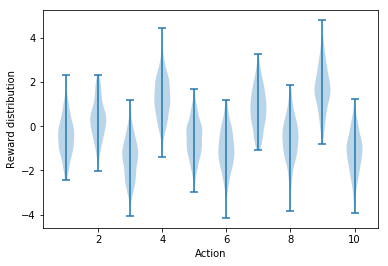

In [12]:
if __name__ == '__main__':
    figure_2_1()

### Conclusion
An example bandit problem from the 10-armed testbed. 
+ The true value $q_*(a)$ of each of the ten actions was selected according to a normal distribution with mean zero and unit variance,
+ Then the actual rewards were selected according to a mean $q_*(a)$ unit variance normal distribution, as suggested by these distributions.

# Ten-armed Testbed II
Average performance of $\epsilon-greedy$ action-value methods on the 10-armed testbed.
These data are averages over 2000 runs with different bandit problems. All methods used sample
averages as their action-value estimates.

<a href="#TOP">
        <span class="toc-item-num">&nbsp;&nbsp;</span>
        TOP
</a>

In [12]:
def figure_2_2(runs=2000, time=1000):
    epsilons = [0, 0.1, 0.01]
    bandits = [Bandit(epsilon=eps, sample_averages=True) for eps in epsilons]
    best_action_counts, rewards = simulate(runs, time, bandits)

    plt.figure(figsize=(10, 20))

    plt.subplot(2, 1, 1)
    for eps, rewards in zip(epsilons, rewards):
        plt.plot(rewards, label='epsilon = %.02f' % (eps))
    plt.xlabel('steps')
    plt.ylabel('average reward')
    plt.legend()

    plt.subplot(2, 1, 2)
    for eps, counts in zip(epsilons, best_action_counts):
        plt.plot(counts, label='epsilon = %.02f' % (eps))
    plt.xlabel('steps')
    plt.ylabel('% optimal action')
    plt.legend()
    plt.show()
    #plt.savefig('../images/figure_2_2.png')
    #plt.close()

100%|██████████| 2000/2000 [00:33<00:00, 60.52it/s]


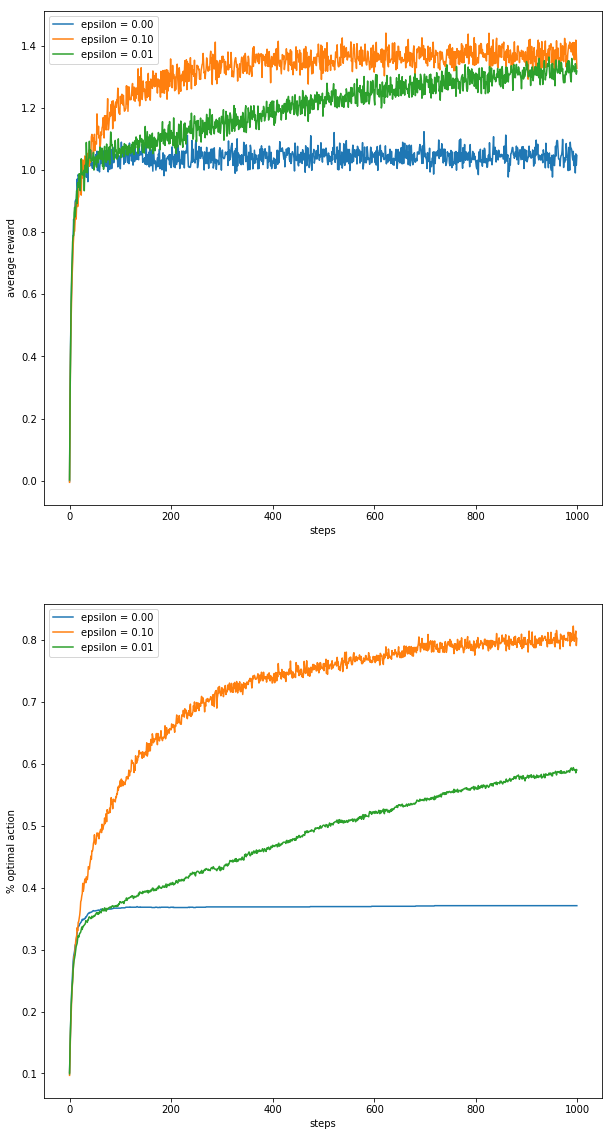

In [13]:
if __name__ == '__main__':
    figure_2_2()

### Conclusion
+ Comparing a greedy method with two $\epsilon-greedy$ methods: $\epsilon=0.01$ and $\epsilon=0.1$ on the 10-armed testbed.
+ All the methods formed their action-value estimates using the sample-average technique.
#### The greedy method
+ The upper graph shows:
    + The increase in expected reward with experience. 
    + Improved slightly faster than the other methods at the very beginning, but then leveled off at a lower level. 
    + It achieved a reward-per-step of only about 1, compared with the best possible of about 1.55 on this testbed. 
    + Performed significantly worse in the long run because it often got stuck performing suboptimal actions. 
+ The lower graph shows:
    + That the greedy method found the optimal action in only approximately one-third of the tasks.
    + In the other two-thirds, its initial samples of the optimal action were disappointing, and it never returned to it.
#### The $\epsilon-greedy$ method    
+ The $\epsilon-greedy$ methods eventually performed better because they continued to explore and to improve their chances of recognizing the optimal action.
+ The upper graph shows:
    + The $\epsilon= 0.1$  method explored more, and usually found the optimal action earlier, but it never selected that action more than 91% of the time.
    + The $\epsilon = 0.01$ method improved more slowly, but eventually would perform better than the $\epsilon= 0.1$ method on both performance measures shown in the figure. 

# Optimistic Initial Values
The effect of optimistic initial action-value estimates on the 10-armed testbed.
Both methods used a constant step-size parameter, $\alpha = 0.1$.

<a href="#TOP">
        <span class="toc-item-num">&nbsp;&nbsp;</span>
        TOP
</a>

In [14]:
def figure_2_3(runs=2000, time=1000):
    bandits = []
    bandits.append(Bandit(epsilon=0, initial=5, step_size=0.1))
    bandits.append(Bandit(epsilon=0.1, initial=0, step_size=0.1))
    best_action_counts, _ = simulate(runs, time, bandits)

    plt.plot(best_action_counts[0], label='epsilon = 0, q = 5')
    plt.plot(best_action_counts[1], label='epsilon = 0.1, q = 0')
    plt.xlabel('Steps')
    plt.ylabel('% optimal action')
    plt.legend()
    plt.show()
    #plt.savefig('../images/figure_2_3.png')
    #plt.close()

In [15]:
if __name__ == '__main__':
    figure_2_3()

 45%|████▍     | 894/2000 [00:15<00:18, 58.33it/s]

KeyboardInterrupt: 

### Conclusion
+ The plot shows the performance on the 10-armed bandit testbed of a greedy methodusing $Q_(a) = +5$, for all a. 
+ For comparison, also shown is an $\epsilon-greedy$ method with $Q_1(a) = 0$. 
+ Initially, the optimistic method performs worse because it explores more, but eventually it performs better because its exploration decreases with time. 
+ This technique for encouraging exploration is called **optimistic initial values**.
+ This simple trick that can be quite effective on stationary problems, but it is far from being a generally useful approach to encouraging exploration. 

# Upper-Confidence-Bound Action Selection
Let's run UCB on the 10-armed testbed. 
+ UCB often performs well, as shown here, but is more difficult than $\epsilon-greedy$ to extend beyond bandits to the more general reinforcement learning settings.
+ One difficulty is in dealing with nonstationary problems; methods more complex than would be needed. 
+ Another diculty is dealing with large state spaces, particularly when using function approximation as we have already explored. 
+ In these more advanced settings the idea of UCB action selection is usually not practical.

<a href="#TOP">
        <span class="toc-item-num">&nbsp;&nbsp;</span>
        TOP
</a>

In [13]:
def figure_2_4(runs=2000, time=1000):
    bandits = []
    bandits.append(Bandit(epsilon=0, UCB_param=2, sample_averages=True))
    bandits.append(Bandit(epsilon=0.1, sample_averages=True))
    _, average_rewards = simulate(runs, time, bandits)

    plt.plot(average_rewards[0], label='UCB c = 2')
    plt.plot(average_rewards[1], label='epsilon greedy epsilon = 0.1')
    plt.xlabel('Steps')
    plt.ylabel('Average reward')
    plt.legend()
    plt.show()
    #plt.savefig('../images/figure_2_4.png')
    #plt.close()

100%|██████████| 2000/2000 [00:31<00:00, 64.19it/s]


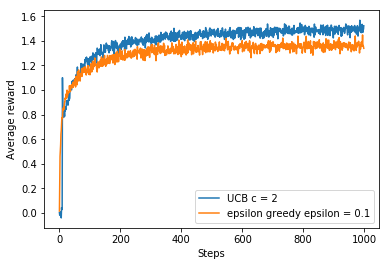

In [14]:
if __name__ == '__main__':
    figure_2_4()

### Conclusion
+ Average performance of UCB action selection on the 10-armed testbed. 
+ As shown,UCB generally performs better than $\epsilon-greedy$ action selection, except in the first k steps, when it selects randomly among the as-yet-untried actions. 

# Gradient Bandits
+ The plot shows results with the gradient bandit algorithm on a variant of the 10-
armed testbed in which the true expected rewards were selected according to a normal
distribution with a mean of +4 instead of zero (and with unit variance as before).
+ This shifting up of all the rewards has absolutely no effect on the gradient bandit algorithm
because of the reward baseline term, which instantaneously adapts to the new level. 
+ But if the baseline were omitted (that is, if $\overline R_t$ was taken to be constant zero), thenperformance would be significantly degraded, as shown in the figure.
<a href="#TOP">
        <span class="toc-item-num">&nbsp;&nbsp;</span>
        TOP
</a>

In [38]:
def figure_2_5(runs=2000, time=1000):
    bandits = []
    bandits.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=True, true_reward=4))
    bandits.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=False, true_reward=4))
    bandits.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=True, true_reward=4))
    bandits.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=False, true_reward=4))
    best_action_counts, _ = simulate(runs, time, bandits)
    labels = ['alpha = 0.1, with baseline',
              'alpha = 0.1, without baseline',
              'alpha = 0.4, with baseline',
              'alpha = 0.4, without baseline']

    for i in range(len(bandits)):
        plt.plot(best_action_counts[i], label=labels[i])
    plt.xlabel('Steps')
    plt.ylabel('% Optimal action')
    plt.legend()
    plt.show()
    #plt.savefig('../images/figure_2_5.png')
    #plt.close()

100%|██████████| 2000/2000 [01:35<00:00, 21.00it/s]


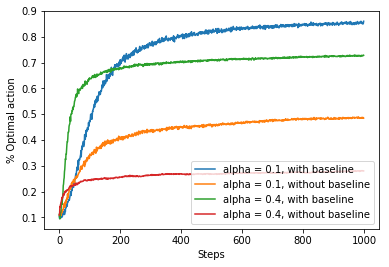

In [39]:
if __name__ == '__main__':
    figure_2_5()

# Parameter Study Graphs
The plot shows a parameter study of the various bandit algorithms presented in this lecture.

Each point is the average reward obtained over 1000 steps with a particular algorithm at a
particular setting of its parameter.
<a href="#TOP">
        <span class="toc-item-num">&nbsp;&nbsp;</span>
        TOP
</a>

In [10]:
def figure_2_6(runs=2000, time=1000):
    labels = ['epsilon-greedy', 'gradient bandit',
              'UCB', 'optimistic initialization']
    generators = [lambda epsilon: Bandit(epsilon=epsilon, sample_averages=True),
                  lambda alpha: Bandit(gradient=True, step_size=alpha, gradient_baseline=True),
                  lambda coef: Bandit(epsilon=0, UCB_param=coef, sample_averages=True),
                  lambda initial: Bandit(epsilon=0, initial=initial, step_size=0.1)]
    parameters = [np.arange(-7, -1, dtype=np.float),
                  np.arange(-5, 2, dtype=np.float),
                  np.arange(-4, 3, dtype=np.float),
                  np.arange(-2, 3, dtype=np.float)]

    bandits = []
    for generator, parameter in zip(generators, parameters):
        for param in parameter:
            bandits.append(generator(pow(2, param)))

    _, average_rewards = simulate(runs, time, bandits)
    rewards = np.mean(average_rewards, axis=1)

    i = 0
    for label, parameter in zip(labels, parameters):
        l = len(parameter)
        plt.plot(parameter, rewards[i:i+l], label=label)
        i += l
    plt.xlabel('Parameter(2^x)')
    plt.ylabel('Average reward')
    plt.legend()
    plt.show()
    #plt.savefig('../images/figure_2_6.png')
    #plt.close()

100%|██████████| 2000/2000 [00:33<00:00, 60.48it/s]


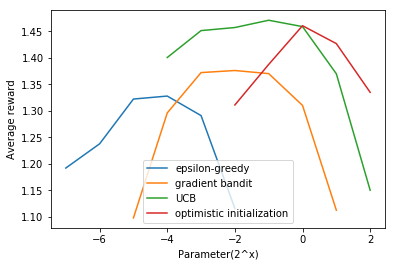

CPU times: user 23min 55s, sys: 14.6 s, total: 24min 9s
Wall time: 23min 32s


In [11]:
%%time
if __name__ == '__main__':
    figure_2_6()

### Conclusion
+ Each as a function of its own parameter shown on a single scale on the x-axis. 
+ This kind of graph is called a **parameter study**. 
+ Note that the parameter values are varied by factors of two and presented on a log scale. 
+ In assessing a method, we should attend not just to how well it does at its best parameter setting, but also to how sensitive it is to its parameter value. 
+ Overall, on this problem, UCB seems to perform best.